In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, accuracy_score, roc_curve, auc
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

In [5]:
# Funzione per caricare i file npy
def load_npy(filename):
    return np.load(filename)

# Configurazione iniziale
dir_path = 'time_series/'
len_threshold = 1280

In [6]:
# Caricamento e preprocessing dei dati
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[:len_threshold]
    else:
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append(ts)

X, y, ids = np.array(X), np.array(y), np.array(ids)


In [7]:
# Normalizzazione delle serie temporali
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

In [38]:

# Trasformazione delle etichette
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_


In [9]:
# Suddivisione del dataset
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.2, random_state=42, stratify=y
)

In [10]:
from pyts.approximation import SymbolicAggregateApproximation

# Approssimazione SAX
sax = SymbolicAggregateApproximation(n_bins=5, strategy='uniform')
X_train_sax = sax.fit_transform(X_train)
X_test_sax = sax.transform(X_test)


In [11]:
# Addestramento del DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_sax, y_train)
y_pred_dummy = dummy_clf.predict(X_test_sax)


In [12]:
# Valutazione del DummyClassifier
precision_dummy = precision_score(y_test, y_pred_dummy, average='macro')
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print(f'DummyClassifier Precision: {precision_dummy}')
print(f'DummyClassifier Accuracy: {accuracy_dummy}')


DummyClassifier Precision: 0.0025
DummyClassifier Accuracy: 0.05


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Shapelets Extraction
# Parametri per la ricerca degli shapelets
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.1, r=1)

shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd", weight_regularizer=0.1, max_iter=200)
shp_clf.fit(X_train, y_train)

shapelets = shp_clf.shapelets_as_time_series_



C:\Users\Alma\anaconda3\Lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


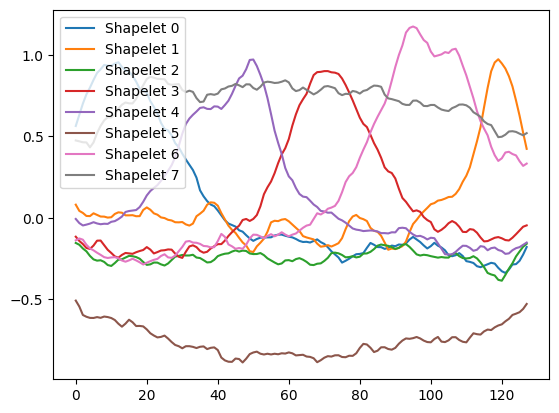

In [42]:
# Visualizzazione degli shapelets trovati (opzionale)
for idx, shapelet in enumerate(shapelets):
    plt.plot(shapelet.ravel(), label=f'Shapelet {idx}')
plt.legend()
plt.show()

In [22]:
# Valutazione del modello Shapelet
y_pred_shp = shp_clf.predict(X_train)

precision_shp = precision_score(y_train, y_pred_shp, average='macro')
accuracy_shp = accuracy_score(y_train, y_pred_shp)

print(f"Shapelet Model - Precision: {precision_shp}, Accuracy: {accuracy_shp}")


Shapelet Model - Precision: 0.03692440488861749, Accuracy: 0.100125


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Trasformare il dataset
X_train_transformed = shp_clf.transform(X_train)
X_test_transformed = shp_clf.transform(X_test)


In [24]:
# KNN Classifier
knn_params = {'n_neighbors': [50], 'weights': ['distance'], 'p': [2], 'metric': ['euclidean']}
knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, knn_params, n_iter=10)
knn_random_search.fit(X_train_transformed, y_train)
knn_best = knn_random_search.best_estimator_

y_pred_knn = knn_best.predict(X_test_transformed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Classifier - Accuracy: {accuracy_knn}")


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KNN Classifier - Accuracy: 0.1505


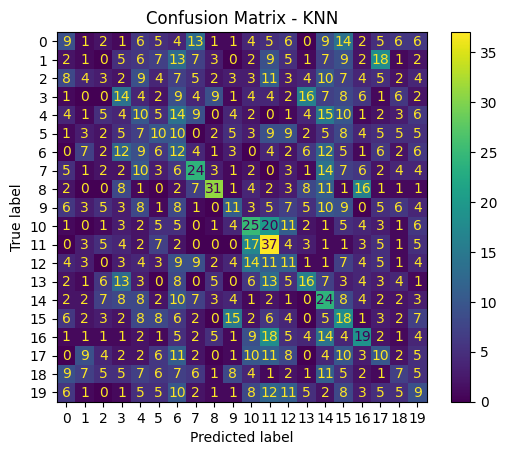

In [25]:
# Confusion Matrix per KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot()
plt.title("Confusion Matrix - KNN")
plt.show()

In [26]:
# Decision Tree Classifier
dt_params = {'max_depth': [6], 'criterion': ['entropy']}
dt = DecisionTreeClassifier()
dt_random_search = RandomizedSearchCV(dt, dt_params, n_iter=10)
dt_random_search.fit(X_train_transformed, y_train)
dt_best = dt_random_search.best_estimator_

y_pred_dt = dt_best.predict(X_test_transformed)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier - Accuracy: {accuracy_dt}")


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Decision Tree Classifier - Accuracy: 0.143


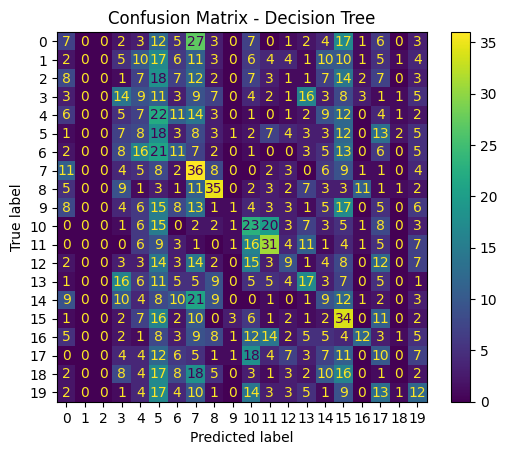

In [27]:
# Confusion Matrix per Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))

for i, shapelet in enumerate(selected_shapelets):
    plt.plot(shapelet, label=f'Shapelet {shapelet_indices[i]} - Genere {shapelet_genres[i]}')

plt.title('Shapelets e Generi Musicali Associati')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [35]:
# ROC Curve per tutte le classi
def plot_multiclass_roc(clf, X_test, y_test, n_classes, class_names):
    y_score = clf.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.jet(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
# Binarizzare l'output
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
n_classes = y_test_binarized.shape[1]

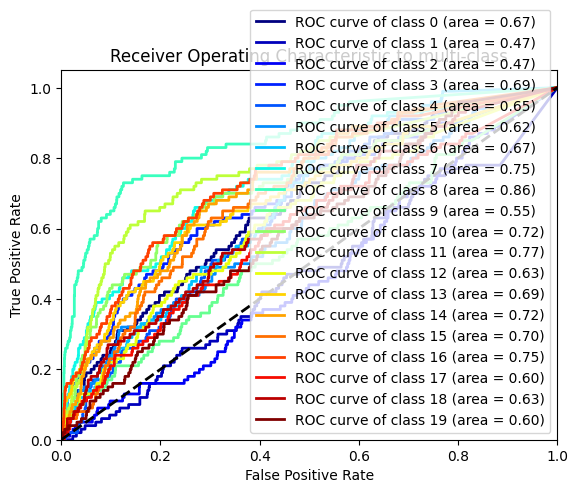

In [40]:
# Plot ROC curve for KNN
plot_multiclass_roc(knn_best, X_test_transformed, y_test_binarized, n_classes, class_names)

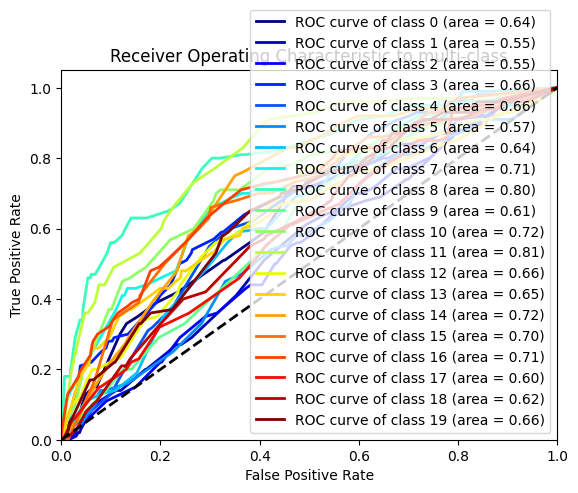

In [41]:
# Plot ROC curve for Decision Tree
plot_multiclass_roc(dt_best, X_test_transformed, y_test_binarized, n_classes, class_names)

In [18]:
f1 = f1_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_shapelet), multi_class='ovr')

print(f'ShapeletModel F1 Score: {f1}')
print(f'ShapeletModel Recall: {recall}')
print(f'ShapeletModel ROC AUC: {roc_auc}')

ShapeletModel F1 Score: 0.1451800981455149
ShapeletModel Recall: 0.15
ShapeletModel ROC AUC: 0.6741305263157894


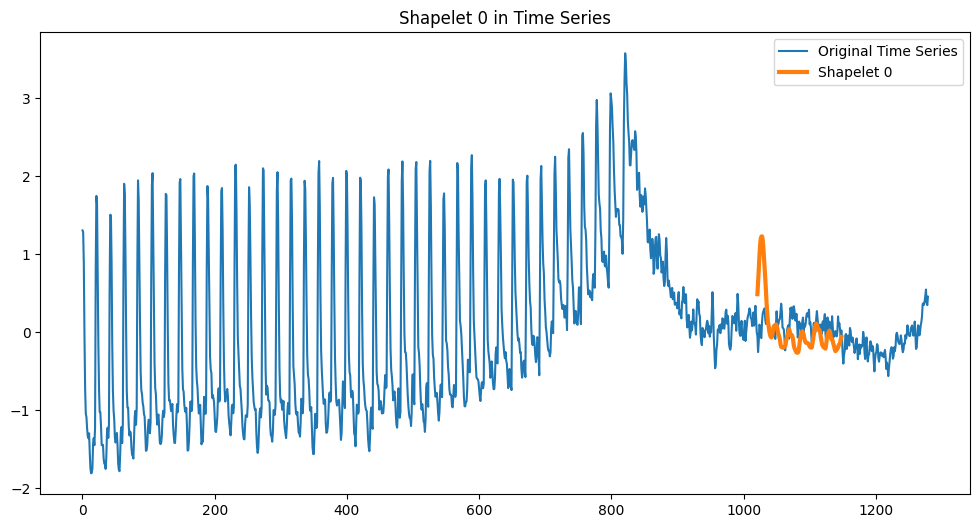

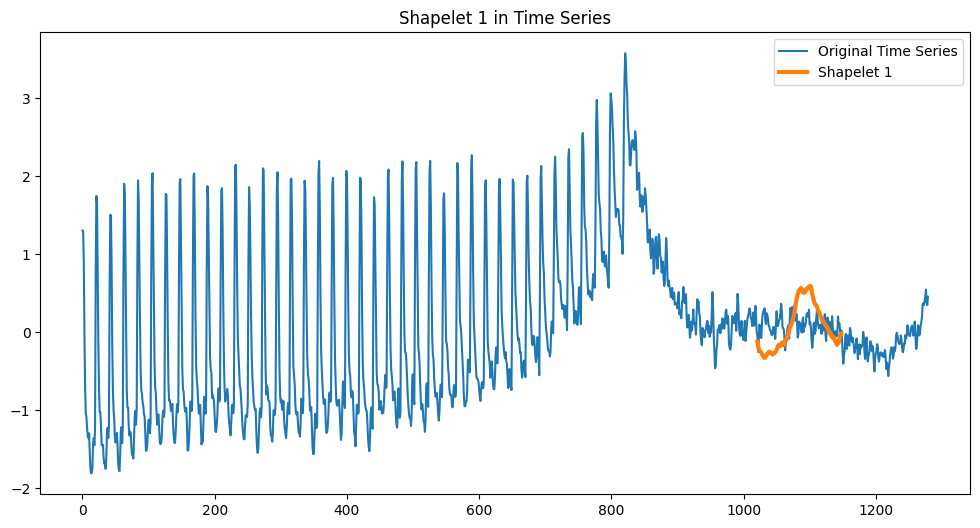

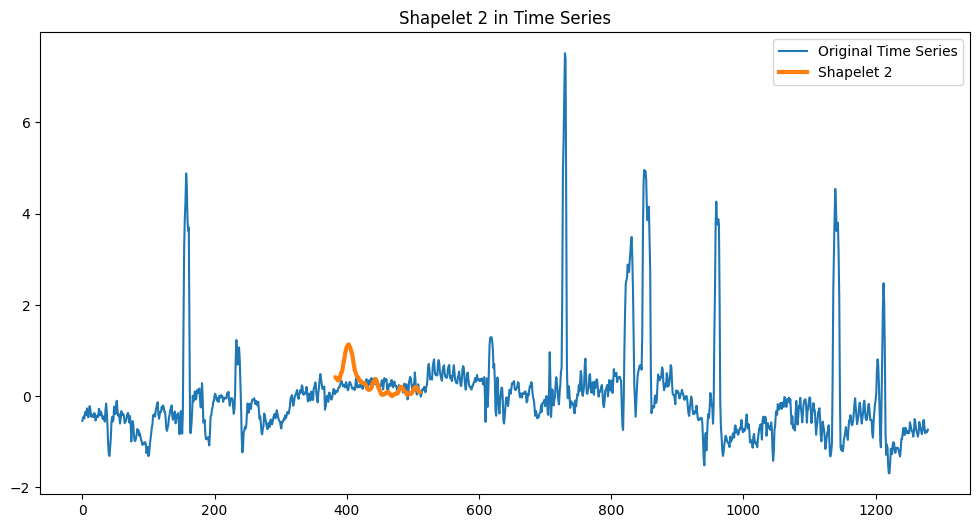

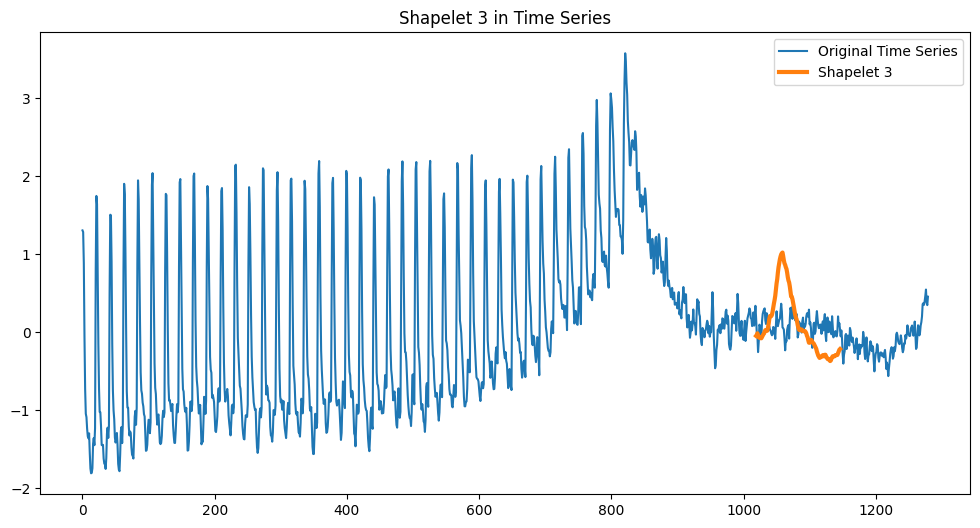

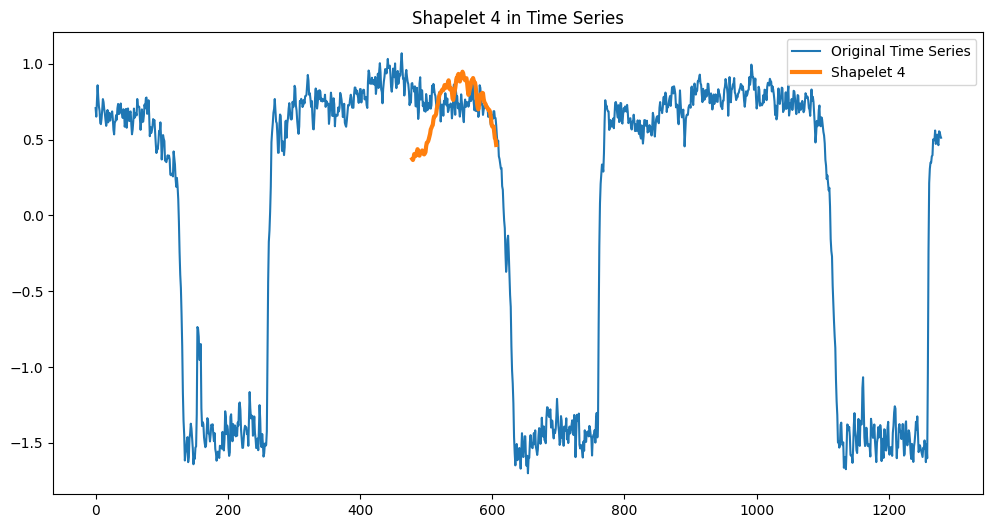

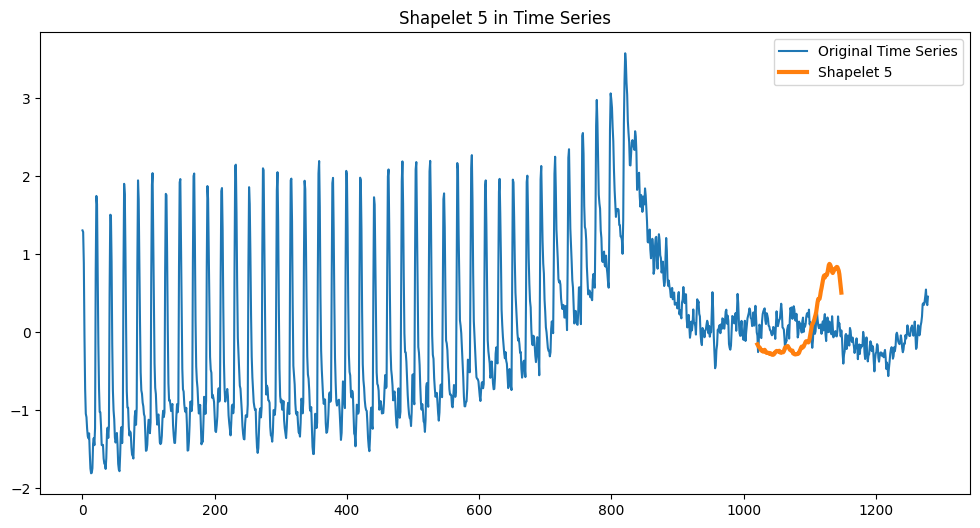

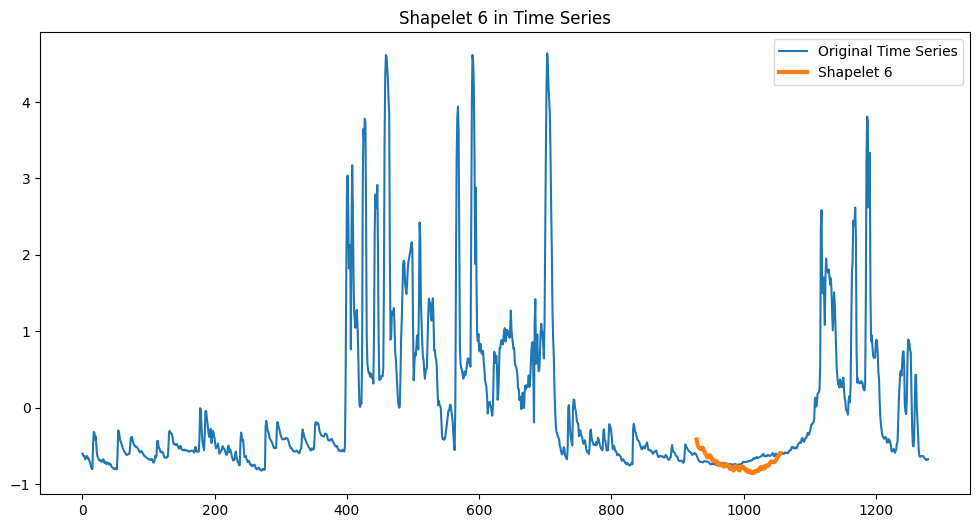

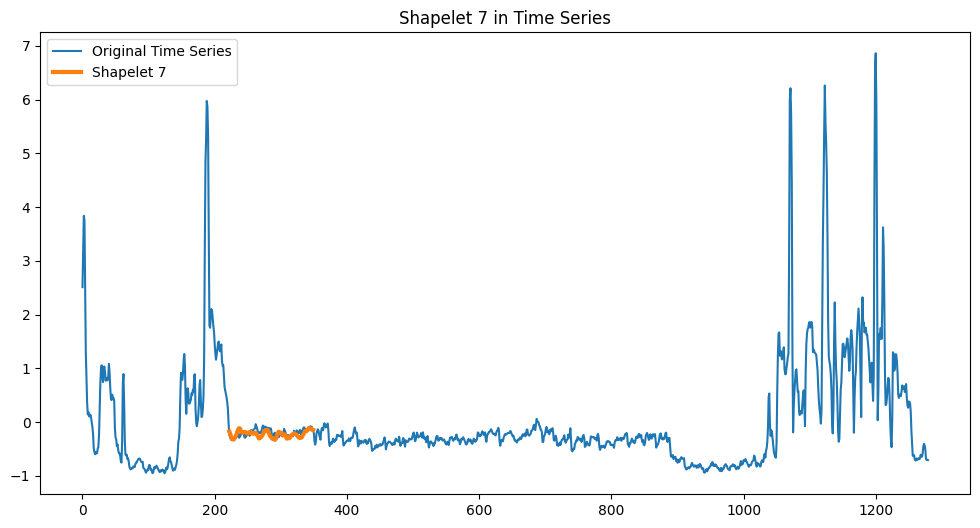

In [19]:
import matplotlib.pyplot as plt

# Funzione per visualizzare shapelet in una serie temporale
def plot_shapelet_in_series(series, shapelet, position, shapelet_id):
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original Time Series')
    plt.plot(range(position, position + len(shapelet)), shapelet, label=f'Shapelet {shapelet_id}', linewidth=3)
    plt.legend()
    plt.title(f'Shapelet {shapelet_id} in Time Series')
    plt.show()

# Trova le posizioni delle shapelets nelle serie temporali
for i, shapelet in enumerate(shapelets):
    min_dist = float('inf')
    best_series = None
    best_pos = None
    
    for j, series in enumerate(X_train):
        # Calcola la distanza di Euclide per ogni sottosequenza della serie temporale
        for start in range(len(series) - len(shapelet) + 1):
            subseq = series[start:start + len(shapelet)]
            dist = np.linalg.norm(subseq - shapelet)
            if dist < min_dist:
                min_dist = dist
                best_series = series
                best_pos = start
                
    # Visualizza la shapelet nella serie temporale
    if best_series is not None and best_pos is not None:
        plot_shapelet_in_series(best_series, shapelet, best_pos, i)


Nel contesto della classificazione di generi musicali, le shapelets rappresentano sottosequenze di segnali musicali che sono altamente discriminanti per riconoscere diverse classi di genere. Ogni shapelet è una sequenza temporale che, quando appare in una traccia musicale, suggerisce fortemente l'appartenenza a un determinato genere.

Significato delle Shapelets
Pattern Discriminanti: Le shapelets sono identificabili come pattern specifici all'interno delle serie temporali musicali che aiutano a distinguere tra diversi generi musicali. Ad esempio, una particolare shapelet potrebbe rappresentare un ritmo, un'intonazione o una caratteristica armonica tipica di un genere musicale specifico.

Posizioni nei Dati Originali: Quando si visualizzano le shapelets nelle serie temporali originali, si può vedere dove queste sottosequenze appaiono nei dati musicali originali. Questo aiuta a capire quali caratteristiche dei segnali musicali sono rilevanti per la classificazione.

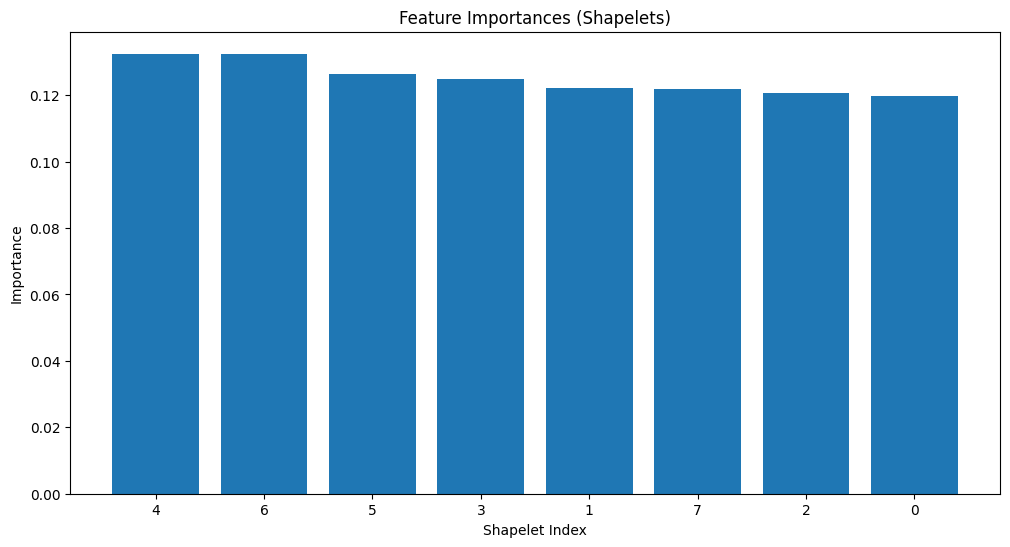

Shapelet 4 Importance: 0.1324615564186533


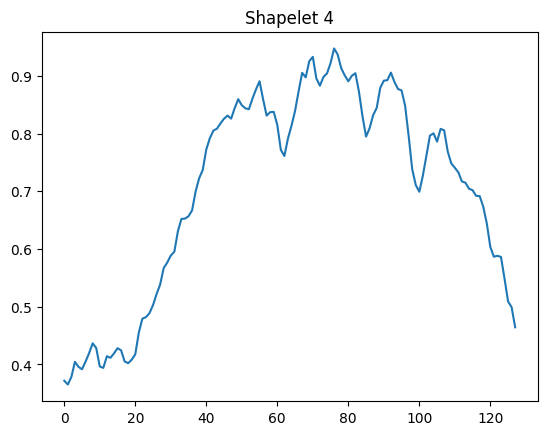

Shapelet 6 Importance: 0.13231058300413187


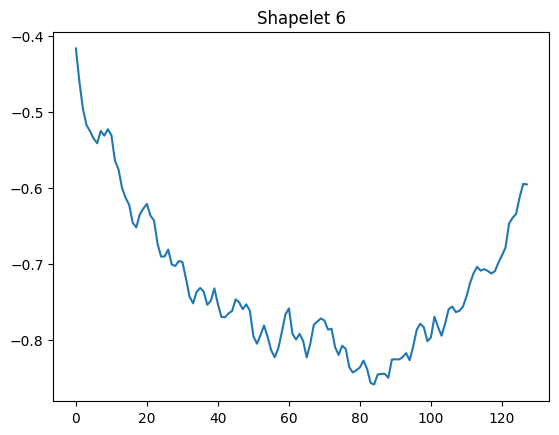

Shapelet 5 Importance: 0.12624373903427102


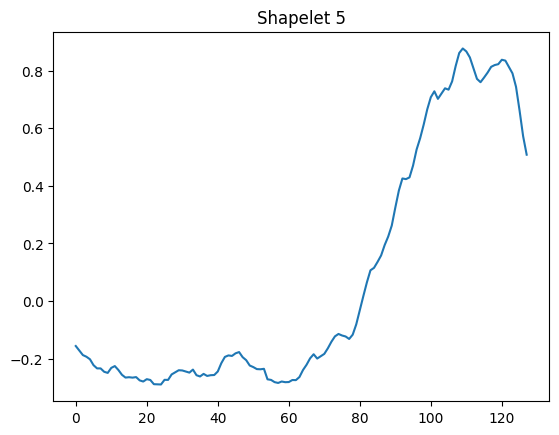

Shapelet 3 Importance: 0.12480247987723582


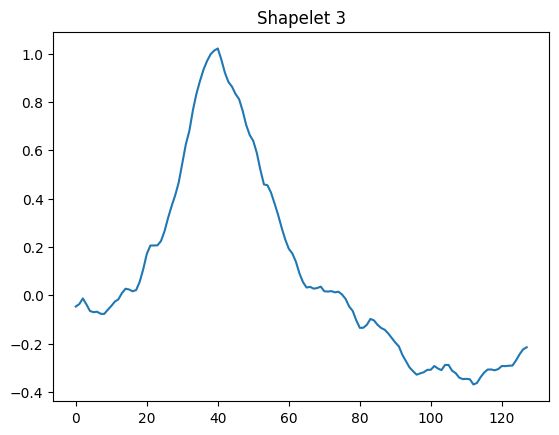

Shapelet 1 Importance: 0.12212888763809661


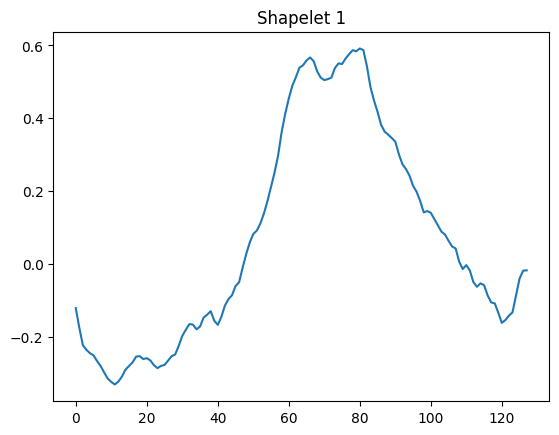

In [20]:
# Ottieni le importanze delle shapelets dal classificatore Random Forest
importances = clf.feature_importances_

# Ordina le importanze e ottieni gli indici delle shapelets più importanti
indices = np.argsort(importances)[::-1]

# Visualizza l'importanza delle shapelets
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Shapelets)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices)
plt.xlabel("Shapelet Index")
plt.ylabel("Importance")
plt.show()

# Stampa le shapelets più importanti
for i in range(5):  # Mostra le prime 5 shapelets più importanti
    print(f'Shapelet {indices[i]} Importance: {importances[indices[i]]}')
    plt.plot(shapelets[indices[i]])
    plt.title(f'Shapelet {indices[i]}')
    plt.show()


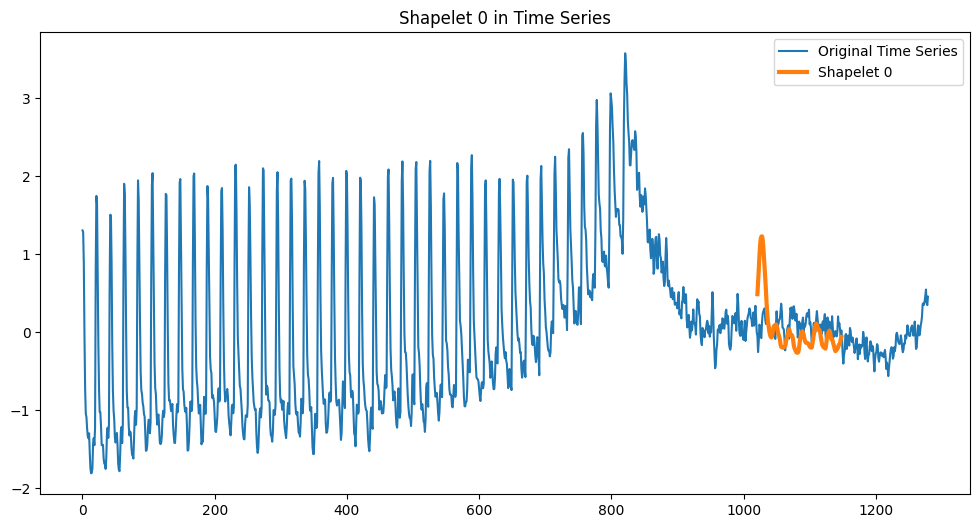

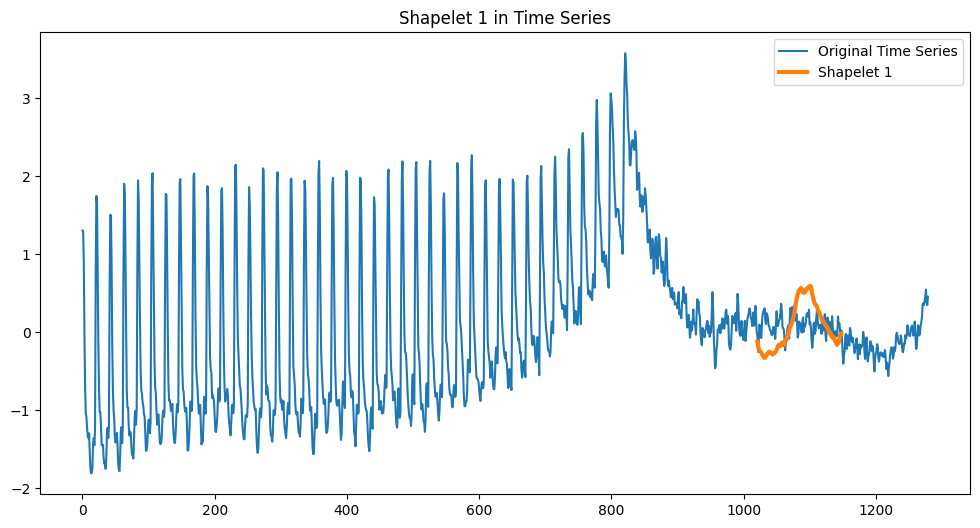

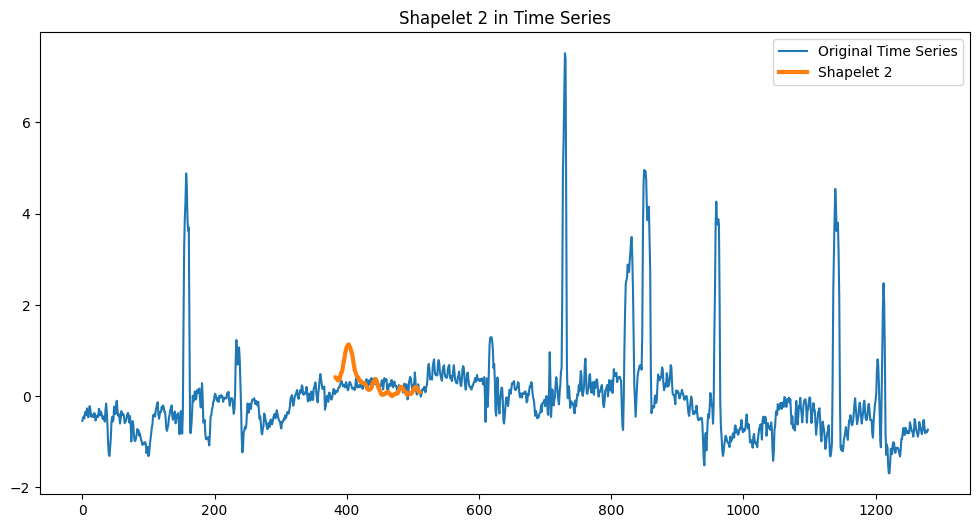

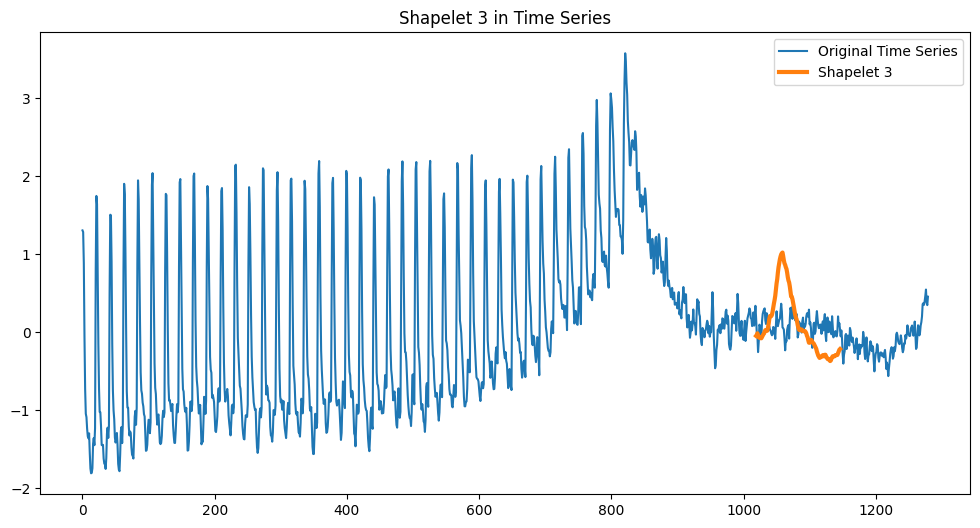

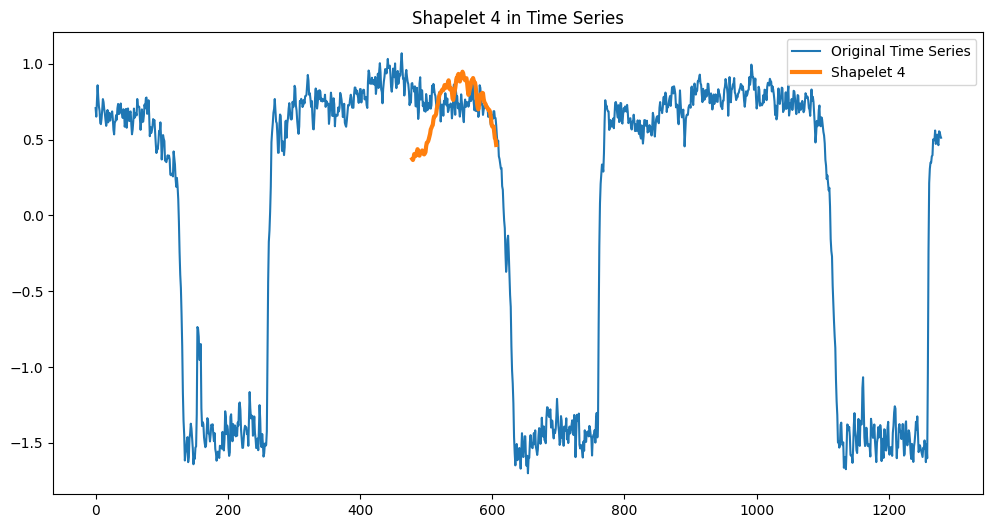

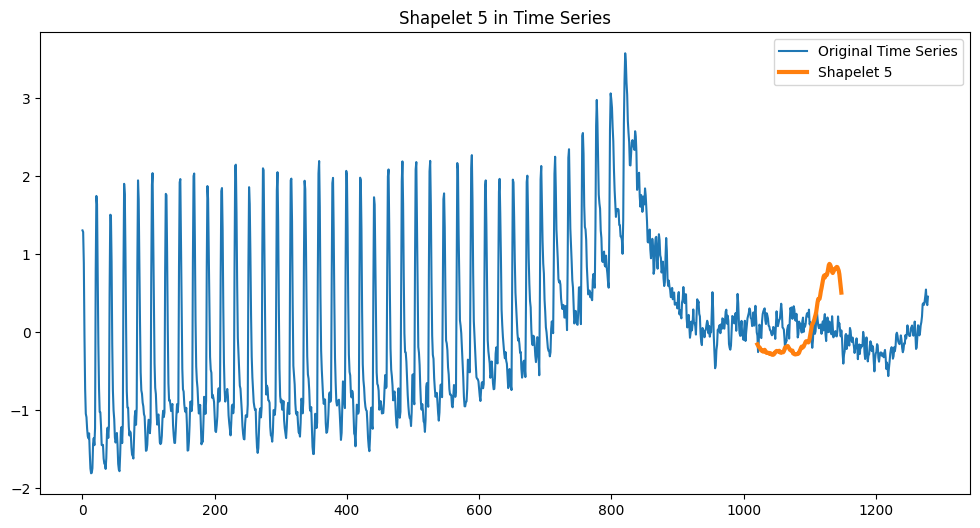

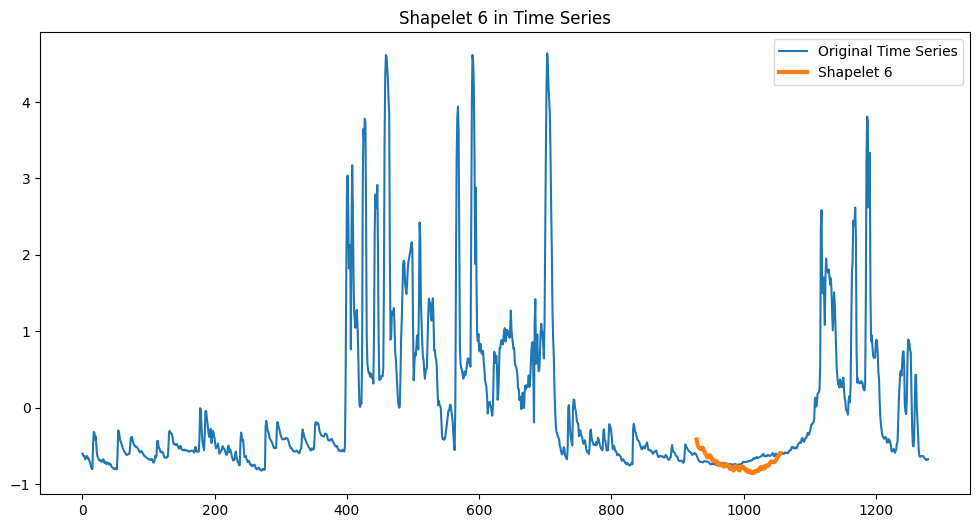

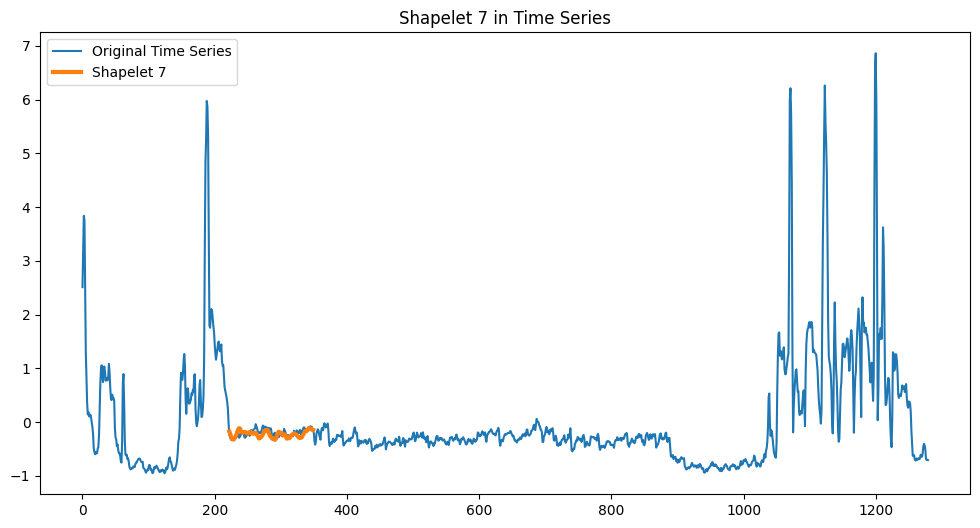

In [21]:
import matplotlib.pyplot as plt

# Funzione per visualizzare shapelet in una serie temporale
def plot_shapelet_in_series(series, shapelet, position, shapelet_id):
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original Time Series')
    plt.plot(range(position, position + len(shapelet)), shapelet, label=f'Shapelet {shapelet_id}', linewidth=3)
    plt.legend()
    plt.title(f'Shapelet {shapelet_id} in Time Series')
    plt.show()

# Trova le posizioni delle shapelets nelle serie temporali
for i, shapelet in enumerate(shapelets):
    min_dist = float('inf')
    best_series = None
    best_pos = None
    
    for j, series in enumerate(X_train):
        # Calcola la distanza di Euclide per ogni sottosequenza della serie temporale
        for start in range(len(series) - len(shapelet) + 1):
            subseq = series[start:start + len(shapelet)]
            dist = np.linalg.norm(subseq - shapelet)
            if dist < min_dist:
                min_dist = dist
                best_series = series
                best_pos = start
                
    # Visualizza la shapelet nella serie temporale
    if best_series is not None and best_pos is not None:
        plot_shapelet_in_series(best_series, shapelet, best_pos, i)


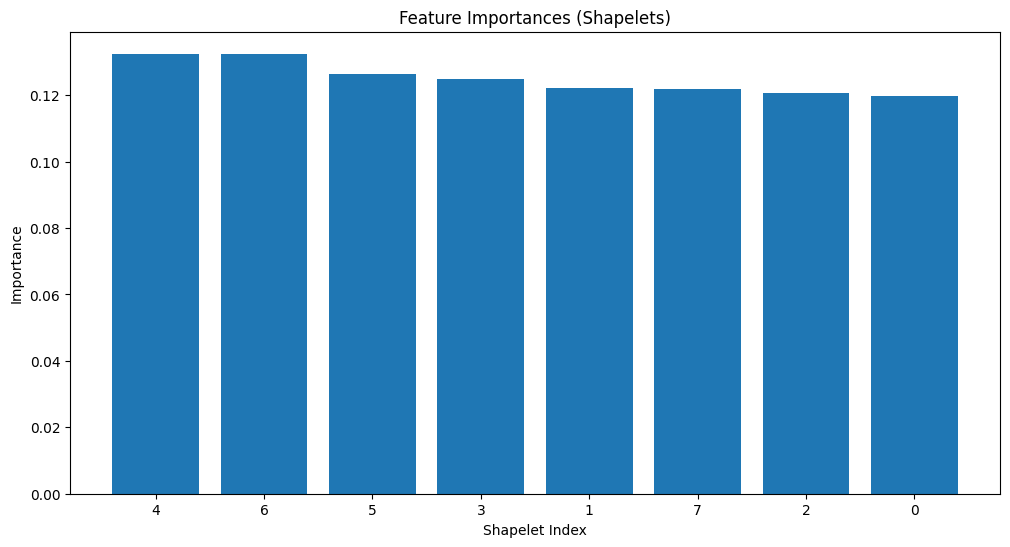

Shapelet 4 Importance: 0.1324615564186533


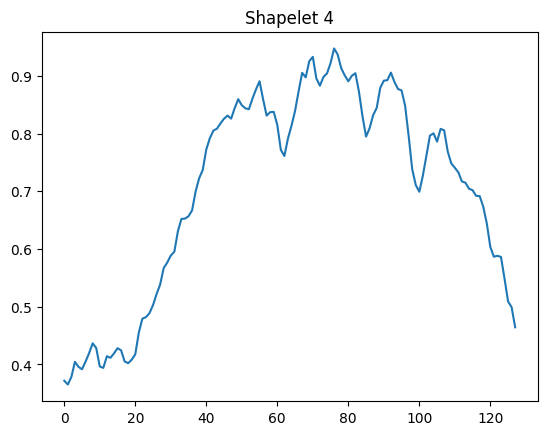

Shapelet 6 Importance: 0.13231058300413187


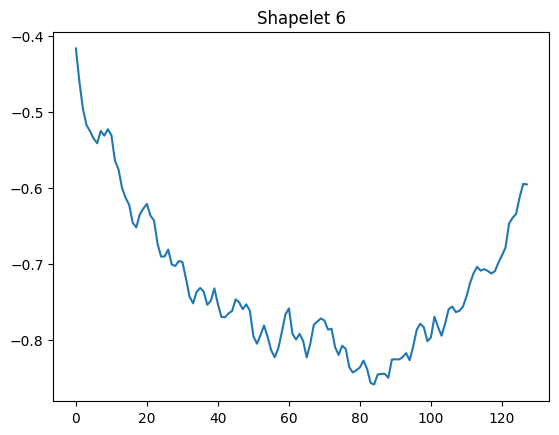

Shapelet 5 Importance: 0.12624373903427102


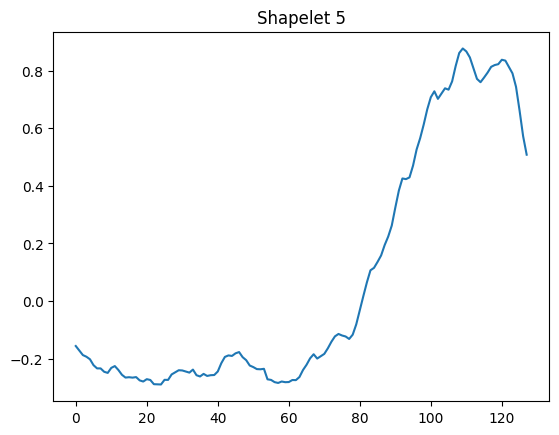

Shapelet 3 Importance: 0.12480247987723582


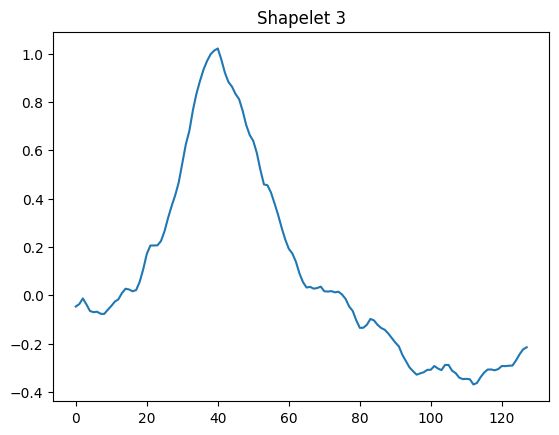

Shapelet 1 Importance: 0.12212888763809661


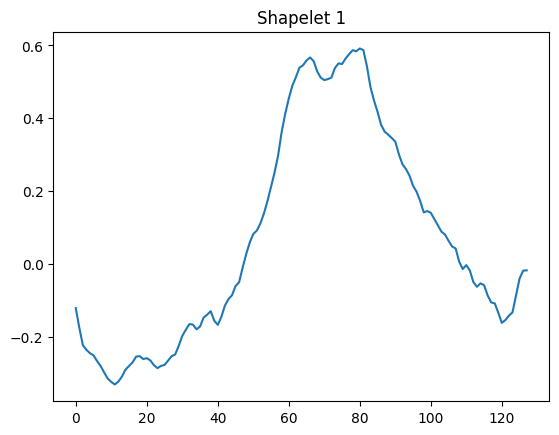

In [22]:
# Ottieni le importanze delle shapelets dal classificatore Random Forest
importances = clf.feature_importances_

# Ordina le importanze e ottieni gli indici delle shapelets più importanti
indices = np.argsort(importances)[::-1]

# Visualizza l'importanza delle shapelets
plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Shapelets)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices)
plt.xlabel("Shapelet Index")
plt.ylabel("Importance")
plt.show()

# Stampa le shapelets più importanti
for i in range(5):  # Mostra le prime 5 shapelets più importanti
    print(f'Shapelet {indices[i]} Importance: {importances[indices[i]]}')
    plt.plot(shapelets[indices[i]])
    plt.title(f'Shapelet {indices[i]}')
    plt.show()


In [26]:
# Supponiamo che le shapelets siano in una lista chiamata 'shapelets'
# Esempio: shapelets = [np.array([...]), np.array([...]), ...]

# Indici delle shapelets di interesse
shapelet_indices = [3, 0, 2, 5, 1, 7]

# Estrazione delle shapelets specifiche
selected_shapelets = [shapelets[i] for i in shapelet_indices]

# Assicurati che le shapelets siano 1-D
selected_shapelets = [shp.flatten() for shp in selected_shapelets]


In [31]:
# Associazioni shapelets -> serie temporali -> generi
shapelet_genres = []
for idx in closest_series_indices:
    shapelet_genres.append(y_train[idx])

# Stampa dei generi associati
for i, genre in enumerate(shapelet_genres):
    print(f'Shapelet {shapelet_indices[i]} è associata al genere {genre}')


Shapelet 3 è associata al genere 1
Shapelet 0 è associata al genere 8
Shapelet 2 è associata al genere 12
Shapelet 5 è associata al genere 16
Shapelet 1 è associata al genere 12
Shapelet 7 è associata al genere 17


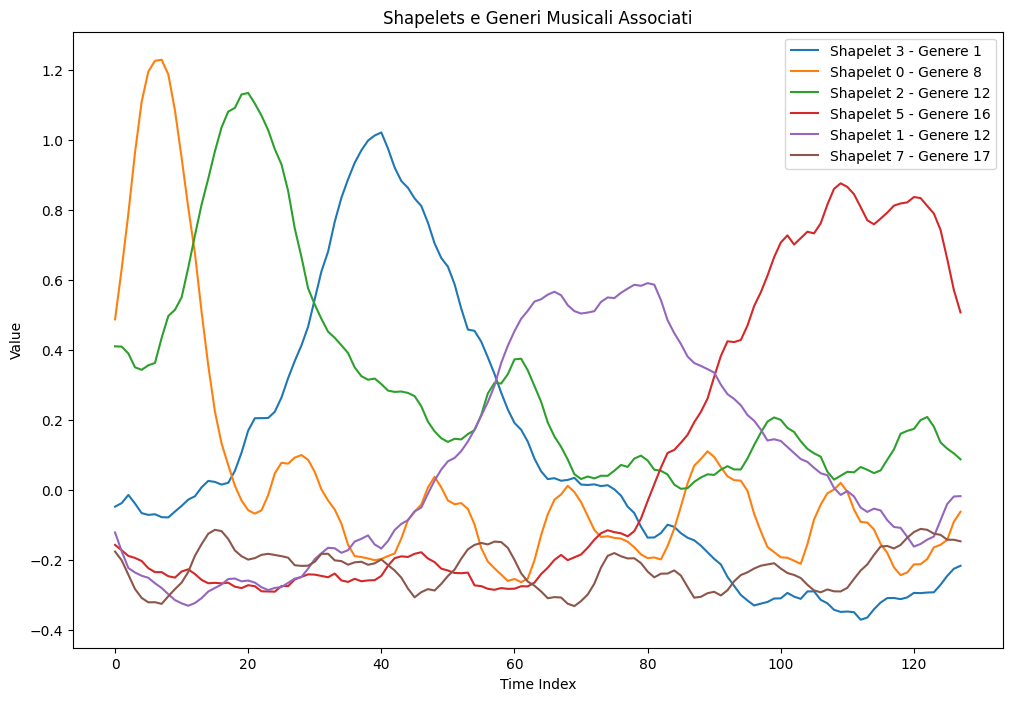

In [32]:
# Visualizzazione delle shapelets e dei loro generi musicali
plt.figure(figsize=(12, 8))

for i, shapelet in enumerate(selected_shapelets):
    plt.plot(shapelet, label=f'Shapelet {shapelet_indices[i]} - Genere {shapelet_genres[i]}')

plt.title('Shapelets e Generi Musicali Associati')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()


Shapelet 3 è associata al genere 1
Shapelet 0 è associata al genere 8
Shapelet 2 è associata al genere 12
Shapelet 5 è associata al genere 16
Shapelet 1 è associata al genere 12
Shapelet 7 è associata al genere 17


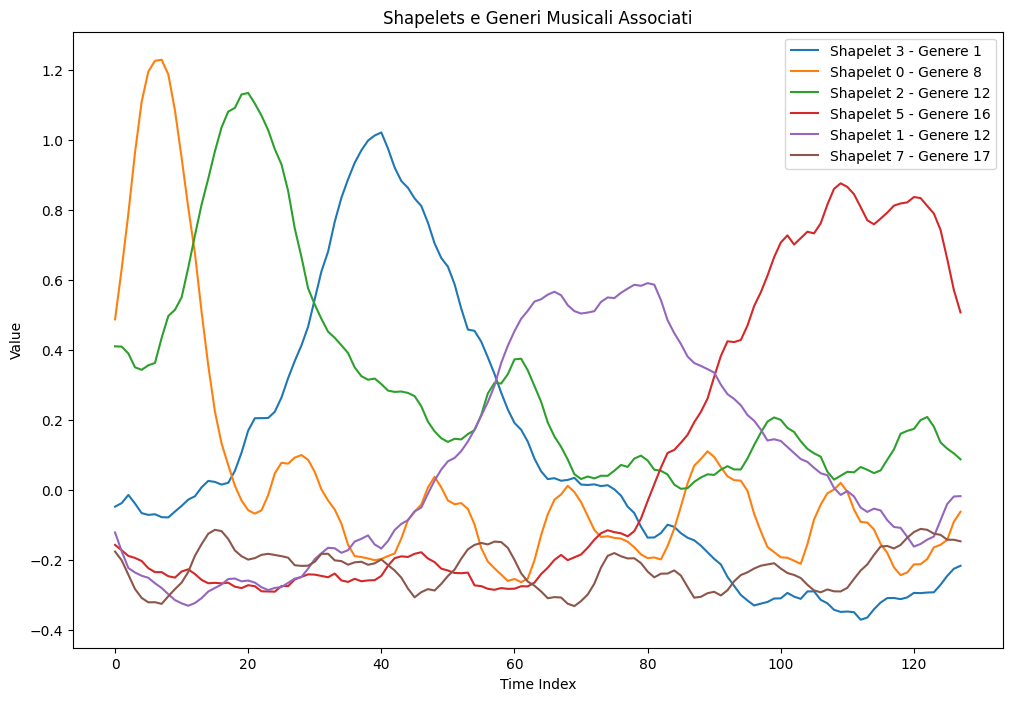

In [34]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Supponiamo che le shapelets siano in una lista chiamata 'shapelets'
# Supponiamo che X_train e y_train siano i dati di training e le etichette dei generi
# Supponiamo che 'ids' contenga i nomi dei generi musicali corrispondenti

# Indici delle shapelets di interesse
shapelet_indices = [3, 0, 2, 5, 1, 7]

# Estrazione delle shapelets specifiche
selected_shapelets = [shapelets[i] for i in shapelet_indices]

# Assicurati che le shapelets siano 1-D
selected_shapelets = [shp.flatten() for shp in selected_shapelets]

# Funzione per estrarre subsequenze
def extract_subsequences(series, shapelet_length):
    subsequences = []
    for i in range(len(series) - shapelet_length + 1):
        subsequences.append(series[i:i + shapelet_length])
    return np.array(subsequences)

# Funzione per trovare la serie temporale più vicina
def find_closest_series(shapelet, X_train):
    shapelet_length = len(shapelet)
    closest_indices = []
    closest_distances = []

    for idx, series in enumerate(X_train):
        series = series.flatten()
        subsequences = extract_subsequences(series, shapelet_length)
        distances = [euclidean(shapelet, subseq) for subseq in subsequences]
        min_distance = min(distances)
        closest_distances.append(min_distance)
        closest_indices.append(idx)

    return np.array(closest_distances), np.array(closest_indices)

# Trova le serie temporali più vicine per ciascuna shapelet
closest_series_indices = []
for shapelet in selected_shapelets:
    distances, indices = find_closest_series(shapelet, X_train)
    min_index = np.argmin(distances)
    closest_series_indices.append(indices[min_index])

# Esegui l'encoding delle etichette originali dei generi
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Ottieni la mappatura da numeri a nomi dei generi
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Funzione per ottenere il nome del genere
def get_genre_name(encoded_label):
    return label_mapping[encoded_label]

# Associazioni shapelets -> serie temporali -> generi
shapelet_genres = []
for idx in closest_series_indices:
    genre_label = y_train[idx]
    genre_name = get_genre_name(genre_label)
    shapelet_genres.append(genre_name)

# Stampa dei generi associati
for i, genre in enumerate(shapelet_genres):
    print(f'Shapelet {shapelet_indices[i]} è associata al genere {genre}')

# Visualizzazione delle shapelets e dei loro generi musicali associati
plt.figure(figsize=(12, 8))

for i, shapelet in enumerate(selected_shapelets):
    plt.plot(shapelet, label=f'Shapelet {shapelet_indices[i]} - Genere {shapelet_genres[i]}')

plt.title('Shapelets e Generi Musicali Associati')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [14]:
# Addestramento del classificatore Random Forest
clf = RandomForestClassifier()
clf.fit(X_train_shapelet, y_train)

# Previsioni sul set di test
y_pred = clf.predict(X_test_shapelet)

# Valutazione del modello
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print(f'ShapeletModel Precision: {precision}')
print(f'ShapeletModel Accuracy: {accuracy}')


ShapeletModel Precision: 0.14480774465653487
ShapeletModel Accuracy: 0.15


In [70]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, accuracy_score, roc_curve, auc
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import euclidean
from scipy.stats import variation
import seaborn as sns
from collections import Counter



In [60]:
 !pip install matrixprofile-ts

# motif

In [71]:
# Funzione per caricare i file npy
def load_npy(filename):
    return np.load(filename)

# Configurazione iniziale
dir_path = 'time_series/'
len_threshold = 1280

# Caricamento e preprocessing dei dati
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre (variabile target)
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[:len_threshold]
    else:
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append(ts)

X, y, ids = np.array(X), np.array(y), np.array(ids)

# Normalizzazione delle serie temporali
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

# Trasformazione delle etichette
le = LabelEncoder()
y = le.fit_transform(y)  # Transformiamo la variabile target genre
class_names = le.classes_

# Suddivisione del dataset
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.2, random_state=42, stratify=y
)

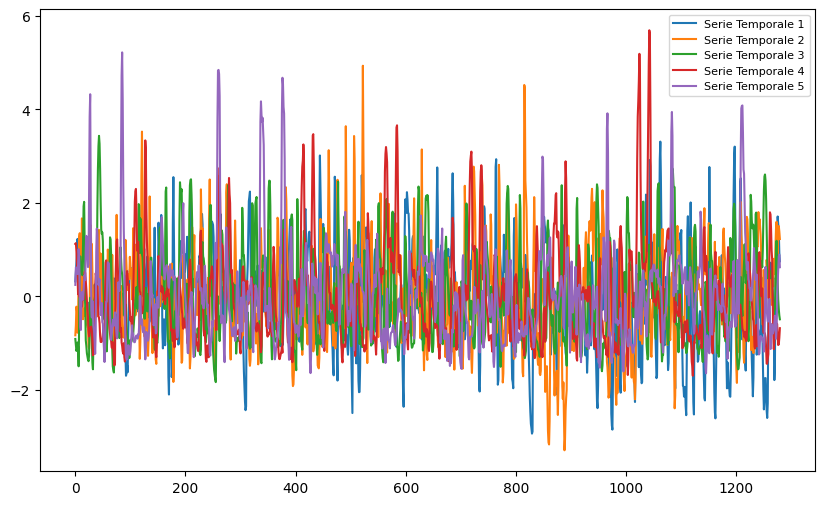

In [44]:
# Visualizzazione di alcune serie temporali
plt.figure(figsize=(10, 6))
for i in range(5):  # Visualizziamo le prime 5 serie temporali
    plt.plot(X_train[i], label=f'Serie Temporale {i+1}')
plt.legend(fontsize=8)
plt.show()


C:\Users\Alma\AppData\Local\Temp\ipykernel_21572\1798593468.py:2: RuntimeWarning: divide by zero encountered in divide
  cv = np.std(X_train, axis=1) / np.mean(X_train, axis=1)


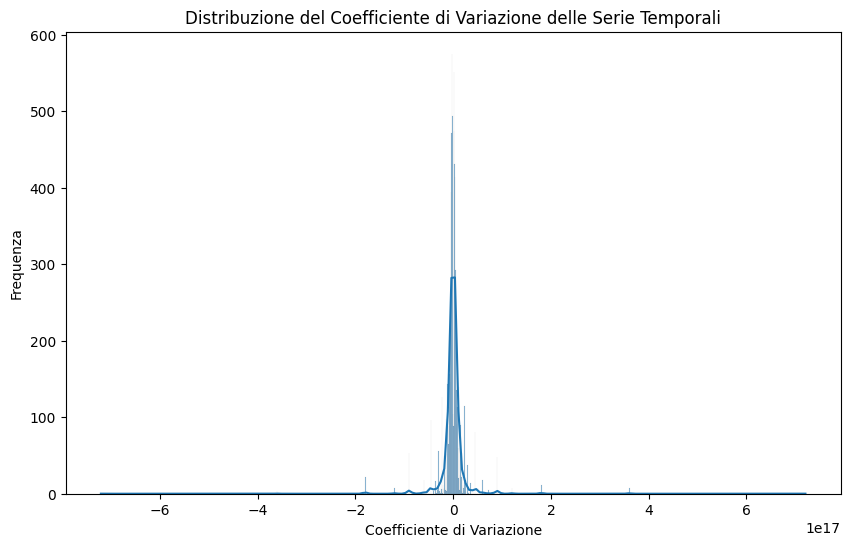

Indice della serie temporale con il coefficiente di variazione più alto: 6


In [51]:
# Calcolo del coefficiente di variazione per ogni serie temporale
cv = np.std(X_train, axis=1) / np.mean(X_train, axis=1)

# Visualizzazione del coefficiente di variazione
plt.figure(figsize=(10, 6))
sns.histplot(cv, kde=True)
plt.title('Distribuzione del Coefficiente di Variazione delle Serie Temporali')
plt.xlabel('Coefficiente di Variazione')
plt.ylabel('Frequenza')
plt.show()

# Selezione della serie temporale con il coefficiente di variazione più alto
index_high_cv = np.argmax(cv)
print(f'Indice della serie temporale con il coefficiente di variazione più alto: {index_high_cv}')


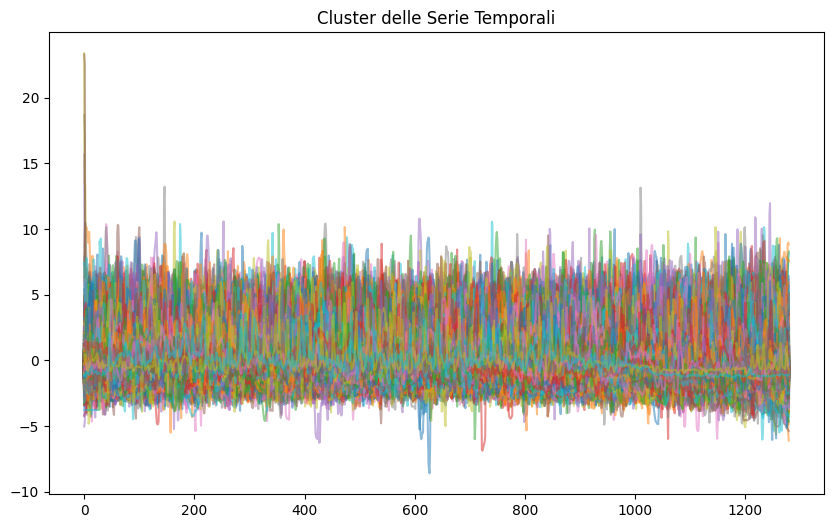

Indici delle serie temporali rappresentative: [3, 5, 1, 9, 0]


In [72]:
from sklearn.cluster import KMeans

# Eseguiamo la cluster analysis
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_train)

# Visualizzazione dei cluster
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    for i in cluster_indices:
        plt.plot(X_train[i], alpha=0.5)
plt.title('Cluster delle Serie Temporali')
plt.show()

# Selezione di una serie temporale rappresentativa per ogni cluster
representative_indices = [np.where(clusters == cluster)[0][0] for cluster in range(n_clusters)]
print(f'Indici delle serie temporali rappresentative: {representative_indices}')


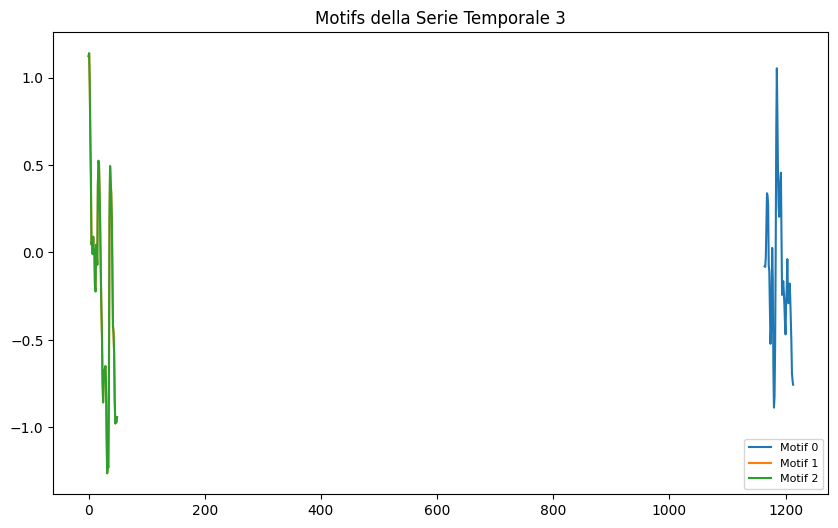

In [76]:

####Estrazione dei Motifs dalla Serie Temporale Selezionata
def find_motifs(time_series, window_size, n_motifs):
    n = len(time_series)
    subsequences = [time_series[i:i+window_size] for i in range(n - window_size + 1)]
    distances = np.zeros((len(subsequences), len(subsequences)))

    for i in range(len(subsequences)):
        for j in range(i+1, len(subsequences)):
            distances[i, j] = np.linalg.norm(subsequences[i] - subsequences[j])
            distances[j, i] = distances[i, j]

    motif_indices = []
    for _ in range(n_motifs):
        min_dist_sum = np.inf
        motif_index = 0
        for i in range(len(subsequences)):
            dist_sum = np.sum(distances[i])
            if dist_sum < min_dist_sum:
                min_dist_sum = dist_sum
                motif_index = i
        motif_indices.append(motif_index)
        distances[motif_index, :] = np.inf
        distances[:, motif_index] = np.inf

    return motif_indices

# Selezioniamo la serie temporale rappresentativa
index_selected = representative_indices[0]  # Puoi cambiare questo indice in base alla strategia scelta
ts_selected = X_train[index_selected]

# Eseguiamo la scoperta dei motifs
window_size = 50
n_motifs = 3
motif_indices = find_motifs(ts_selected, window_size, n_motifs)

# Visualizzazione dei motifs trovati
plt.figure(figsize=(10, 6))
motifs = [ts_selected[i:i+window_size] for i in motif_indices]
for idx, motif in enumerate(motifs):
    plt.plot(range(motif_indices[idx], motif_indices[idx]+window_size), motif, label=f'Motif {idx}')
plt.legend(fontsize=8)
plt.title(f'Motifs della Serie Temporale {index_selected}')
plt.show()


In [77]:
#confronto tra shap e mot

# Otteniamo gli shapelets come serie temporali
shapelets = shp_clf.shapelets_as_time_series_

# Filtriamo i shapelets con la stessa lunghezza dei motifs (window_size)
filtered_shapelets = [shapelet for shapelet in shapelets if len(shapelet) == window_size]

# Calcoliamo la distanza euclidea tra i shapelets filtrati e i motifs
distances = []
for shapelet in filtered_shapelets:
    min_distance = float('inf')
    for motif in motifs:
        distance = euclidean(shapelet.ravel(), motif)
        if distance < min_distance:
            min_distance = distance
    distances.append(min_distance)

# Stampa dei risultati
print("Distanze euclidee tra gli shapelets e i motifs:", distances)


Distanze euclidee tra gli shapelets e i motifs: []


In [78]:
# Trasformare il dataset
X_train_transformed = shp_clf.transform(X_train)
X_test_transformed = shp_clf.transform(X_test)

# KNN Classifier
knn_params = {'n_neighbors': [50], 'weights': ['distance'], 'p': [2], 'metric': ['euclidean']}
knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, knn_params, n_iter=10)
knn_random_search.fit(X_train_transformed, y_train)
knn_best = knn_random_search.best_estimator_

y_pred_knn = knn_best.predict(X_test_transformed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Classifier - Accuracy: {accuracy_knn}")

# Decision Tree Classifier
dt_params = {'max_depth': [6], 'criterion': ['entropy']}
dt = DecisionTreeClassifier()
dt_random_search = RandomizedSearchCV(dt, dt_params, n_iter=10)
dt_random_search.fit(X_train_transformed, y_train)
dt_best = dt_random_search.best_estimator_

y_pred_dt = dt_best.predict(X_test_transformed)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier - Accuracy: {accuracy_dt}")


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KNN Classifier - Accuracy: 0.1505


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Decision Tree Classifier - Accuracy: 0.143


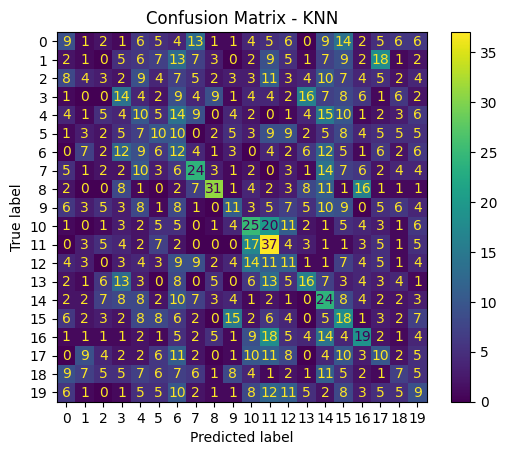

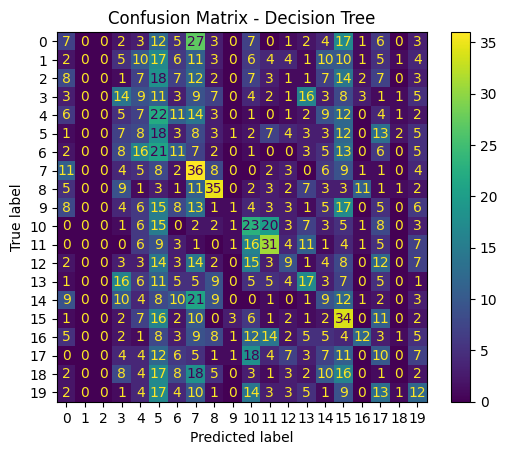

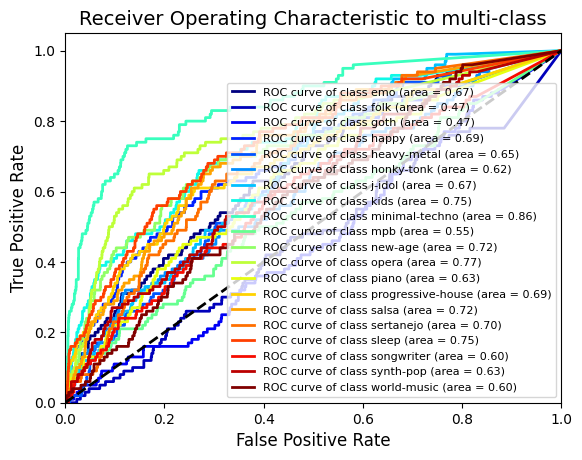

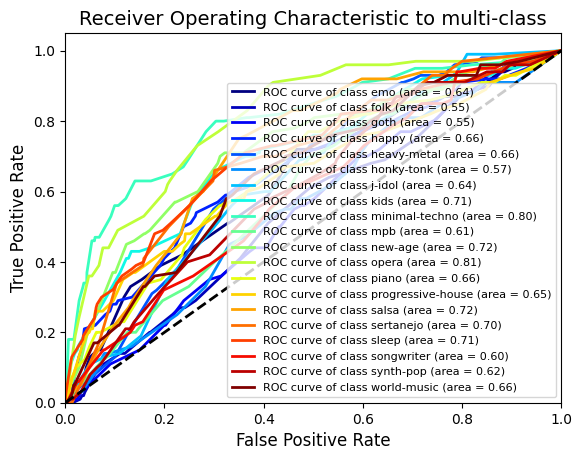

In [79]:
# Confusion Matrix per KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot()
plt.title("Confusion Matrix - KNN")
plt.show()

# Confusion Matrix per Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Funzione per plottare la ROC curve per problemi multi-classe
def plot_multiclass_roc(clf, X_test, y_test, n_classes, class_names):
    y_score = clf.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.jet(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic to multi-class', fontsize=14)
    plt.legend(loc="lower right", fontsize=8)
    plt.show()

# Binarizzare l'output
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
n_classes = y_test_binarized.shape[1]

# Plot ROC curve for KNN
plot_multiclass_roc(knn_best, X_test_transformed, y_test_binarized, n_classes, class_names)

# Plot ROC curve for Decision Tree
plot_multiclass_roc(dt_best, X_test_transformed, y_test_binarized, n_classes, class_names)


In [80]:
# Estrazione degli Shapelets con la Lunghezza Specificata
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict

# Parametri per la ricerca degli shapelets con lunghezza dei motifs
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))
shapelet_sizes = {50: 6}  # Estrarre 6 shapelets di lunghezza 50

shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd", weight_regularizer=0.1, max_iter=200)
shp_clf.fit(X_train, y_train)

# Otteniamo gli shapelets come serie temporali
shapelets = shp_clf.shapelets_as_time_series_

# Verifichiamo le lunghezze degli shapelets
shapelet_lengths = [len(shapelet) for shapelet in shapelets]
print(f'Lunghezze degli shapelets: {shapelet_lengths}')


C:\Users\Alma\anaconda3\Lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Lunghezze degli shapelets: [50, 50, 50, 50, 50, 50]


In [81]:
# Calcoliamo la distanza euclidea tra i shapelets e i motifs
distances = []
for shapelet in shapelets:
    min_distance = float('inf')
    for motif in motifs:
        if len(shapelet.ravel()) == len(motif):  # Assicuriamoci che abbiano la stessa lunghezza
            distance = euclidean(shapelet.ravel(), motif)
            if distance < min_distance:
                min_distance = distance
    distances.append(min_distance)

# Stampa dei risultati
print("Distanze euclidee tra gli shapelets e i motifs:", distances)


Distanze euclidee tra gli shapelets e i motifs: [3.482846069266619, 8.030533241606237, 5.884431318143042, 5.062008432505564, 3.224302792420195, 5.302610698274218]


In [82]:
# Trasformare il dataset
X_train_transformed = shp_clf.transform(X_train)
X_test_transformed = shp_clf.transform(X_test)

# KNN Classifier
knn_params = {'n_neighbors': [50], 'weights': ['distance'], 'p': [2], 'metric': ['euclidean']}
knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, knn_params, n_iter=10)
knn_random_search.fit(X_train_transformed, y_train)
knn_best = knn_random_search.best_estimator_

y_pred_knn = knn_best.predict(X_test_transformed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Classifier - Accuracy: {accuracy_knn}")

# Decision Tree Classifier
dt_params = {'max_depth': [6], 'criterion': ['entropy']}
dt = DecisionTreeClassifier()
dt_random_search = RandomizedSearchCV(dt, dt_params, n_iter=10)
dt_random_search.fit(X_train_transformed, y_train)
dt_best = dt_random_search.best_estimator_

y_pred_dt = dt_best.predict(X_test_transformed)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier - Accuracy: {accuracy_dt}")


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KNN Classifier - Accuracy: 0.159


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Decision Tree Classifier - Accuracy: 0.1345


In [83]:
# Trasformare il dataset
X_train_transformed = shp_clf.transform(X_train)
X_test_transformed = shp_clf.transform(X_test)

# KNN Classifier
knn_params = {'n_neighbors': [50], 'weights': ['distance'], 'p': [2], 'metric': ['euclidean']}
knn = KNeighborsClassifier()
knn_random_search = RandomizedSearchCV(knn, knn_params, n_iter=10)
knn_random_search.fit(X_train_transformed, y_train)
knn_best = knn_random_search.best_estimator_

y_pred_knn = knn_best.predict(X_test_transformed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Classifier - Accuracy: {accuracy_knn}")

# Decision Tree Classifier
dt_params = {'max_depth': [6], 'criterion': ['entropy']}
dt = DecisionTreeClassifier()
dt_random_search = RandomizedSearchCV(dt, dt_params, n_iter=10)
dt_random_search.fit(X_train_transformed, y_train)
dt_best = dt_random_search.best_estimator_

y_pred_dt = dt_best.predict(X_test_transformed)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier - Accuracy: {accuracy_dt}")


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KNN Classifier - Accuracy: 0.159


C:\Users\Alma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Decision Tree Classifier - Accuracy: 0.1345


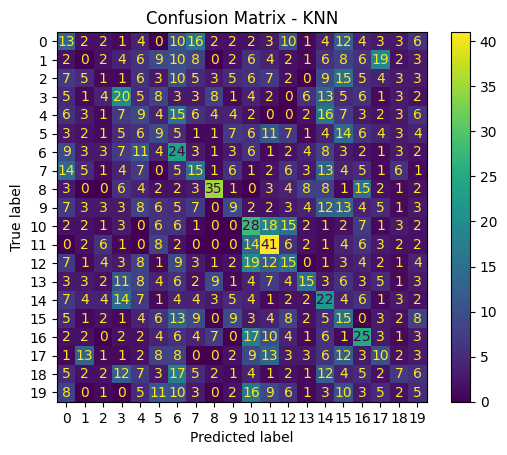

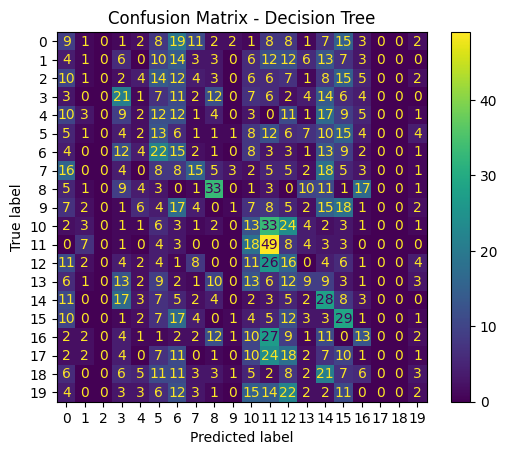

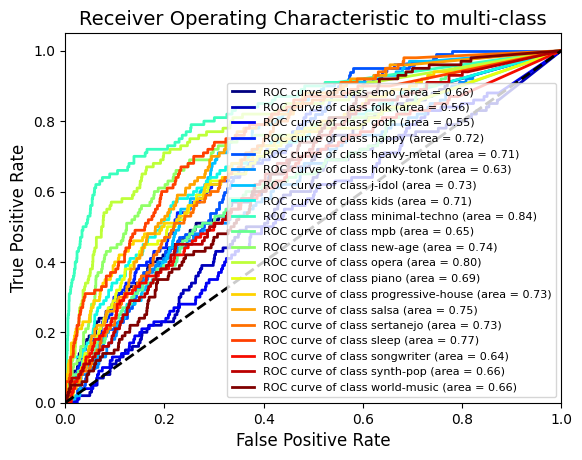

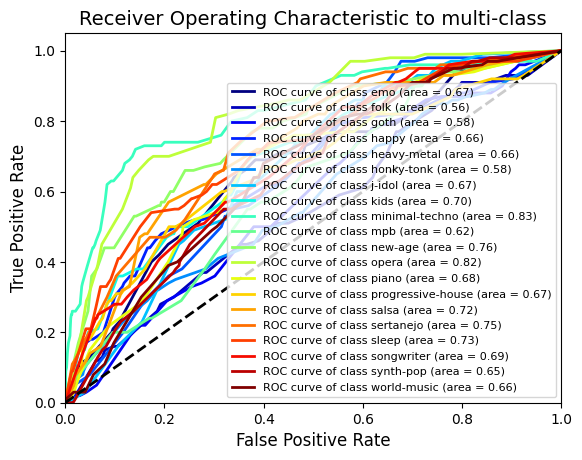

In [84]:
# Confusion Matrix per KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm_knn).plot()
plt.title("Confusion Matrix - KNN")
plt.show()

# Confusion Matrix per Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot()
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Funzione per plottare la ROC curve per problemi multi-classe
def plot_multiclass_roc(clf, X_test, y_test, n_classes, class_names):
    y_score = clf.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.jet(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic to multi-class', fontsize=14)
    plt.legend(loc="lower right", fontsize=8)
    plt.show()

# Binarizzare l'output
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
n_classes = y_test_binarized.shape[1]

# Plot ROC curve for KNN
plot_multiclass_roc(knn_best, X_test_transformed, y_test_binarized, n_classes, class_names)

# Plot ROC curve for Decision Tree
plot_multiclass_roc(dt_best, X_test_transformed, y_test_binarized, n_classes, class_names)
